In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from skimage import color
from skimage import io
from scipy import stats
from skimage.feature import graycomatrix, graycoprops

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Download original sat image 

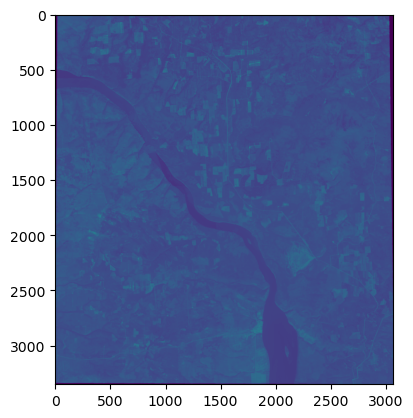

In [3]:
#downloading and preparing satellite image

#path to Sentinell-2 L2A tiff file 
fname='../rasters/bands_and_terrain.tiff'

img = rasterio.open(fname)

red = img.read(4)
green = img.read(3)
blue = img.read(2)
nir = img.read(8)

def normalize(band):
    band[np.isnan(band)] = 0.
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def remove_zero_pad(image):
    dummy = np.argwhere(image != 0) # assume blackground is zero
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()
    crop_image = image[min_y:max_y, min_x:max_x]

    return crop_image

red_b=normalize(remove_zero_pad(red))
blue_b=normalize(remove_zero_pad(blue))
green_b=normalize(remove_zero_pad(green))
nir_b=normalize(remove_zero_pad(nir))

rgb_composite= np.dstack((red_b, green_b, blue_b))
img_grayscale = color.rgb2gray(rgb_composite)
img_grayscale[img_grayscale==0.] = 0.03


plt.imshow(img_grayscale)

### Download feature maps

In [4]:
fm_raw = np.load('/home/apetrovskaya/ForestMapping/textures/haralicks_con_dis_hom.npy')
fm2_raw = np.load('/home/apetrovskaya/ForestMapping/textures/haralicks_asm_en_corr.npy')

In [5]:
fm = fm_raw[..., (0,1,3,4)]
fm2 = fm2_raw[..., (0,1,3,4)]
fms = np.concatenate([fm,fm2],axis=2)

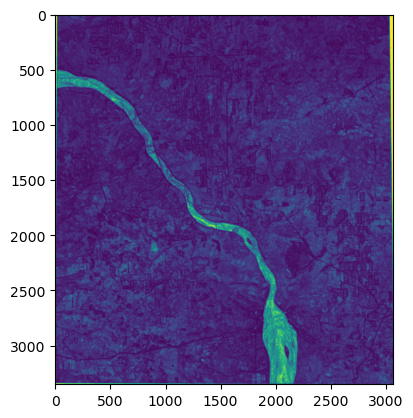

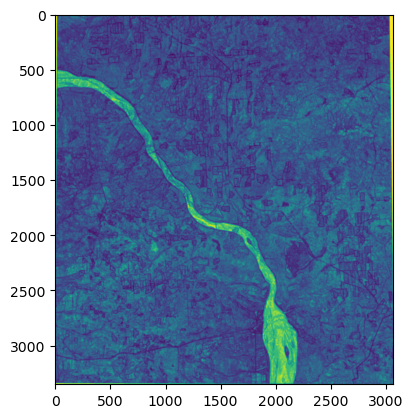

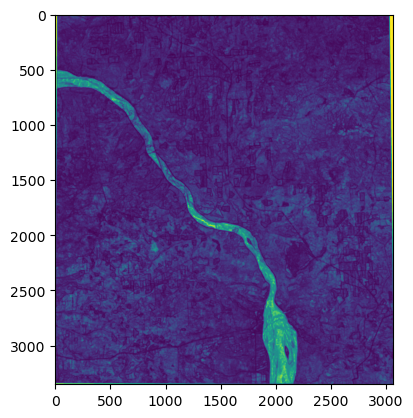

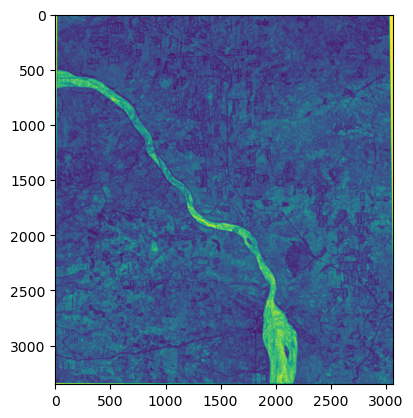

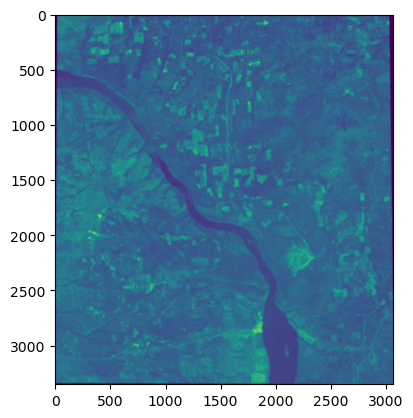

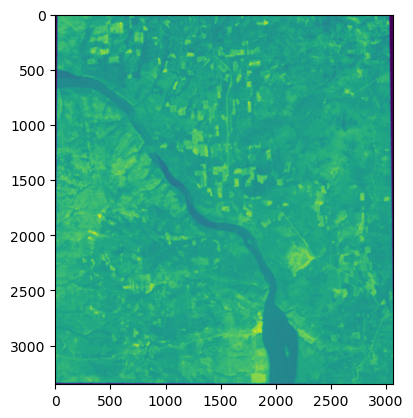

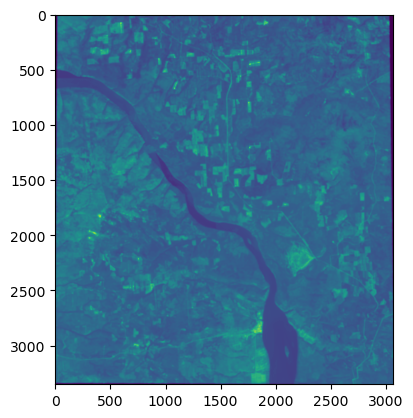

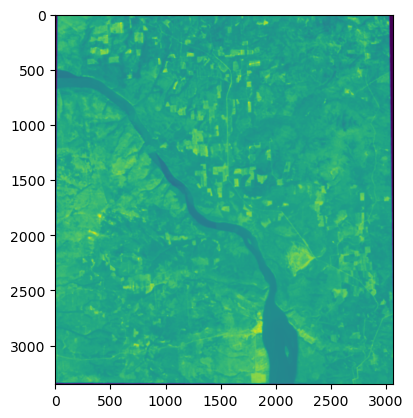

In [6]:
for i in range(fms.shape[2]):
    ax,fig = plt.subplots(1,1)
    plt.imshow(fms[...,i])

In [7]:
fm_df = pd.DataFrame(fms.reshape(fms.shape[0]*fms.shape[1],fms.shape[2]))

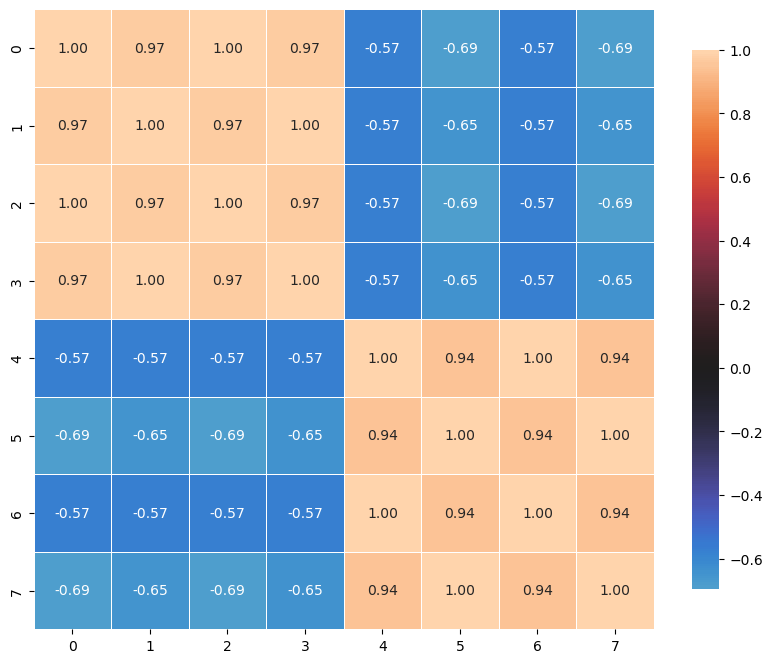

In [8]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

correlation_heatmap(fm_df)

In [9]:
feature_map = np.concatenate([fm_raw,fm2_raw],axis=2)
props = ('contrast1', 'contrast2', 'dissimilarity1', 'dissimilarity2', 'homogeneity1', 'homogeneity2', 'ASM1', 'ASM2', 'energy1', 'energy2', 'correlation1', 'correlation2')

In [10]:
red.shape

(3461, 3159)

In [ ]:
from osgeo import gdal
from osgeo.gdalconst import GDT_Int16, GDT_Float64

for i, prop in zip(range(feature_map.shape[2]),props):
    
    values = feature_map[...,i]

    dummy = np.argwhere(red != 0) # assume blackground is zero
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()

    fm_with_zeros = red.copy()
    fm_with_zeros[min_y:max_y, min_x:max_x] = values

    in_data = gdal.Open('/home/apetrovskaya/ForestMapping/rasters/bands_and_terrain.tiff')
    driver = in_data.GetDriver()
    out_data = driver.Create('/home/apetrovskaya/ForestMapping/textures/'+str(prop)+'.tiff', 3159, 3461, 1, GDT_Float64)
    dem_data = np.array(fm_with_zeros)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    #out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    out_data.FlushCache()